# Regression Analysis
## Model
$$ Supply: P = aQ + sigma $$
$$ Demand: P = aQ + b*Income + c*subscriptionRate + d*Race + e*Age + f*Borough + sigma $$
$$ P = aQ + bIncome + c*subscriptionRate + Race + Age + Borough + sigma $$

The regression is done in both demand and supply side. Our datasets include the latest FCC fixed broadband dataset in 2019, ACS demographic datasets for income, age and race, in 2010 and ACS subscription dataset in 2018. For comparison, we also did the regression using FCC and ACS datasets in 2017.

## Data preparation
### Independent variables: Income, Race, Age, Borough

In [1]:
import pandas as pd
import numpy as np

In [2]:
# import Income data in percentage
income = pd.read_csv('data/Demographics/Income/household_income_acs2018.csv')
income = income.sort_values(by='tract')
income = income.drop(columns=['city','tract','Households (HH) Count','Household Median Income','Household Mean Income'])
income.columns = income.columns.str.replace('HH ', '')
income['BoroCTLbl'] = income['BoroCTLbl'].astype(str)
income.head()

,county,BoroCTLbl,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,k100_k150,k150_k200,k200_UP
0,Bronx,Bronx 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1100,Manhattan,Manhattan 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1388,Queens,Queens 1,4.9,0.3,2.5,2.2,2.6,8.2,10.5,20.9,15.8,32.2
339,Brooklyn,Brooklyn 1,3.2,2.2,9.4,2.7,5.0,14.0,19.3,9.8,13.9,20.5
340,Brooklyn,Brooklyn 2,11.6,5.3,6.1,23.8,10.8,21.1,6.4,8.6,1.1,5.3


In [3]:
# Race data in percentage
race = pd.read_csv('data/Demographics/Basic Count/tract_race_acs2018.csv')
race = race.assign(White = lambda x: x["White"]/x["Total"]*100,
                  Black = lambda x: x["Black"]/x["Total"]*100,
                  Native = lambda x: x["Native"]/x["Total"]*100,
                  Asian = lambda x: x["Asian"]/x["Total"]*100,
                  PacificIslander = lambda x: x["Pacific_Islander"]/x["Total"]*100,
                  Other = lambda x: x["Other"]/x["Total"]*100,
                  TwoOrMore = lambda x: x["Two or More"]/x["Total"]*100)
race = race.fillna(0)
race = race.drop(columns=['city','county','Total','Two or More','Pacific_Islander']).sort_values(by='tract')
race['BoroCTLbl'] = race['BoroCTLbl'].astype(str)
race.head()

,tract,BoroCTLbl,White,Black,Native,Asian,Other,PacificIslander,TwoOrMore
23,1.0,Bronx 1,25.042373,59.872881,0.353107,1.765537,12.005650,0.0,0.960452
907,1.0,Brooklyn 1,65.280572,15.157612,0.715404,8.920188,5.902079,0.0,4.024145
1225,1.0,Manhattan 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1742,1.0,Queens 1,64.054360,5.594564,0.000000,22.808607,2.061155,0.0,5.481314
590,2.0,Brooklyn 2,45.132743,3.861625,0.000000,4.987932,41.029767,0.0,4.987932


In [4]:
# Age data
age = pd.read_csv('data/Demographics/Age_Sex/tract_age_sex_acs2018.csv')
age = age.sort_values(by='tract')
age = age.drop(columns=['Male','Female'])
for i in range(5,len(age.columns)):
    age.iloc[:,i] = age.iloc[:,i]/age.loc[:,'Total']*100
age = age.fillna(0)
age = age.drop(columns=['tract','county','city','Total'])
age['BoroCTLbl'] = age['BoroCTLbl'].astype(str)
age.head()

,BoroCTLbl,A00_A05,A05_A09,A10_A14,A15_A19,A20_A24,A25_A29,A30_A34,A35_A39,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
0,Bronx 1,0.000000,0.000000,0.000000,7.641243,15.805085,14.449153,14.731638,13.516949,9.957627,8.375706,8.629944,4.788136,1.384181,0.720339,0.000000,0.000000,0.000000,0.000000
1100,Manhattan 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1388,Queens 1,10.192525,4.903737,1.155153,0.826727,2.740657,14.530011,20.928652,13.091733,9.331823,8.505096,4.043035,3.816535,2.627407,0.486976,1.778029,1.041903,0.000000,0.000000
339,Brooklyn 1,4.560698,4.381847,2.638051,3.822938,1.922647,7.467024,7.780013,8.562486,8.338922,11.133467,6.751621,5.097250,7.802370,9.300246,3.241672,3.264029,0.804829,3.129890
340,Brooklyn 2,3.459372,8.286404,8.688656,5.390185,8.769107,12.228479,11.263073,5.390185,6.436042,9.654063,6.275141,4.666130,0.884956,3.459372,1.126307,1.287208,1.528560,1.206758


In [5]:
# Borough data
borough = income.iloc[:,:2]
borough_name = ['Bronx','Brooklyn','Queens','Manhattan','Staten Island']
for i in borough_name:
    borough[i] = 0
for i in range(len(borough)):
    boro = borough.loc[i,'county']
    borough.loc[i,boro] = 1
borough = borough.drop(columns=['county'])
borough['BoroCTLbl'] = borough['BoroCTLbl'].astype(str)
borough.columns = borough.columns.str.replace('Staten Island', 'Staten_Island')
borough.head() 

,BoroCTLbl,Bronx,Brooklyn,Queens,Manhattan,Staten_Island
0,Bronx 1,1,0,0,0,0
1100,Manhattan 1,0,0,0,1,0
1388,Queens 1,0,0,1,0,0
339,Brooklyn 1,0,1,0,0,0
340,Brooklyn 2,0,1,0,0,0


### Broadband data

In [6]:
import geopandas as gpd
census_tracts = gpd.read_file("data/2010_Census_Tracts/geo_export_0ca1f0a1-f242-497a-9f86-91b88fc18647.shp")

In [7]:
# number of internet providers Q
# 2-digit code indicating the Technology of Transmission used to offer broadband service. 
def tech_code_translator(x):
    # ADSL, Cable, Fiber, Fixed Wireless, Satellite, Other
    if x in ['10', '11', '12', '20', '30']:
        return 'ADSL'
    if x in ['40', '41', '42', '43']:
        return 'Cable'
    if x == '50':
        return 'Fiber'
    if x == '60':
        return 'Satellite'
    if x == '70':
        return 'Fixed Wireless'
    return 'Other'
converters = {'tract': lambda x: str(x), 
              'block': lambda x: str(x),
              'Technology Code': lambda x: tech_code_translator(x)
             }
fcc477_broadband = pd.read_csv('data/Fixed_Broadband_Deployment_Data__Jun__2019_Status_V1.csv',converters = converters, encoding = "ISO-8859-1")
fcc477_broadband.rename(columns={'Census Block FIPS Code':'FIPS Code'}, inplace=True)
# get FIPS 11: state + county + tract
fcc477_broadband["FIPS Code"] = fcc477_broadband["FIPS Code"].astype(str)
fcc477_broadband["FIPS_11"] = fcc477_broadband["FIPS Code"].str[:11]
# filter for unique providers in each tract that provide broadband service
fcc477_broadband = fcc477_broadband[(fcc477_broadband["Max Advertised Downstream Speed (mbps)"]>=25.0)&(fcc477_broadband["Max Advertised Upstream Speed (mbps)"]>=3.0)]

In [8]:
broadband_ISP = fcc477_broadband.groupby(["FIPS_11", "boro"]).agg(
    providers = pd.NamedAgg(column = "Provider Name", aggfunc = lambda x: set(x)))

broadband_ISP.reset_index(inplace=True)
broadband_ISP["ct2010"] = broadband_ISP["FIPS_11"].str[5:]
broadband_ISP["boro"] = broadband_ISP["boro"].replace({"bronx": "Bronx",
                                                                    "brooklyn": "Brooklyn",
                                                                    "manhattan": "Manhattan",
                                                                    "staten island": "Staten Island",
                                                                    "queens": "Queens"})
for i in range(len(broadband_ISP)):
    broadband_ISP.loc[i,'providers'] = list(broadband_ISP.loc[i,'providers'])
# merge
broadband_ISP_merged = broadband_ISP.merge(census_tracts.loc[:,["boro_name", "ct2010", "ctlabel"]], right_on = ["ct2010", "boro_name"], left_on = ["ct2010", "boro"])
# new common column
broadband_ISP_merged["BoroCTLbl"] = broadband_ISP_merged["boro_name"] + " " + broadband_ISP_merged["ctlabel"].astype(str)
for i in range(len(broadband_ISP_merged)):
    broadband_ISP_merged.loc[i,'num_providers'] = len(broadband_ISP_merged.loc[i,'providers'])

broadband_ISP_merged = broadband_ISP_merged.drop(columns=['FIPS_11','ct2010','boro_name'])
broadband_ISP_merged.head()

,boro,providers,ctlabel,BoroCTLbl,num_providers
0,Bronx,"[ViaSat, Inc., HNS License Sub, LLC, RCN Telec...",1,Bronx 1,3.0
1,Bronx,"[ViaSat, Inc., HNS License Sub, LLC, Verizon N...",2,Bronx 2,4.0
2,Bronx,"[ViaSat, Inc., HNS License Sub, LLC, Verizon N...",4,Bronx 4,4.0
3,Bronx,"[ViaSat, Inc., HNS License Sub, LLC, Verizon N...",16,Bronx 16,4.0
4,Bronx,"[ViaSat, Inc., HNS License Sub, LLC, Verizon N...",19,Bronx 19,4.0


In [9]:
# get 2017 data
fcc477_broadband = pd.read_csv('data/Fixed_Broadband_Deployment_Data__Jun__2017_Status_V1.csv',converters = converters, encoding = "ISO-8859-1")
fcc477_broadband.rename(columns={'Census Block FIPS Code':'FIPS Code'}, inplace=True)
# get FIPS 11: state + county + tract
fcc477_broadband["FIPS Code"] = fcc477_broadband["FIPS Code"].astype(str)
fcc477_broadband["FIPS_11"] = fcc477_broadband["FIPS Code"].str[:11]
# filter for unique providers in each tract that provide broadband service
fcc477_broadband = fcc477_broadband[(fcc477_broadband["Max Advertised Downstream Speed (mbps)"]>=25.0)&(fcc477_broadband["Max Advertised Upstream Speed (mbps)"]>=3.0)]
broadband_ISP = fcc477_broadband.groupby(["FIPS_11", "boro"]).agg(
    providers = pd.NamedAgg(column = "Provider Name", aggfunc = lambda x: set(x)))
broadband_ISP.reset_index(inplace=True)
broadband_ISP["ct2010"] = broadband_ISP["FIPS_11"].str[5:]
broadband_ISP["boro"] = broadband_ISP["boro"].replace({"bronx": "Bronx",
                                                                    "brooklyn": "Brooklyn",
                                                                    "manhattan": "Manhattan",
                                                                    "staten island": "Staten Island",
                                                                    "queens": "Queens"})
for i in range(len(broadband_ISP)):
    broadband_ISP.loc[i,'providers'] = list(broadband_ISP.loc[i,'providers'])
# merge
broadband_ISP_merged_2017 = broadband_ISP.merge(census_tracts.loc[:,["boro_name", "ct2010", "ctlabel"]], right_on = ["ct2010", "boro_name"], left_on = ["ct2010", "boro"])
# new common column
broadband_ISP_merged_2017["BoroCTLbl"] = broadband_ISP_merged_2017["boro_name"] + " " + broadband_ISP_merged_2017["ctlabel"].astype(str)
for i in range(len(broadband_ISP_merged_2017)):
    broadband_ISP_merged_2017.loc[i,'num_providers'] = len(broadband_ISP_merged_2017.loc[i,'providers'])
broadband_ISP_merged_2017 = broadband_ISP_merged_2017.drop(columns=['FIPS_11','ct2010','boro_name'])
broadband_ISP_merged_2017.head()

,boro,providers,ctlabel,BoroCTLbl,num_providers
0,Bronx,"[ViaSat, Inc., HNS License Sub, LLC, RCN Telec...",1,Bronx 1,3.0
1,Bronx,"[ViaSat, Inc., HNS License Sub, LLC, Verizon N...",2,Bronx 2,4.0
2,Bronx,"[ViaSat, Inc., HNS License Sub, LLC, Verizon N...",4,Bronx 4,4.0
3,Bronx,"[ViaSat, Inc., HNS License Sub, LLC, Verizon N...",16,Bronx 16,4.0
4,Bronx,"[ViaSat, Inc., HNS License Sub, LLC, Verizon N...",19,Bronx 19,4.0


Calculate prices in each census tract. Idealy, for both broadband and mobile, we need to know how many people register for one certain plan of one company, and then calculate the weighted average price in this tract. 

In [10]:
all_provider = []
for i in range(len(broadband_ISP_merged)):
    for value in broadband_ISP_merged.loc[i,'providers']:
        all_provider.append(value)
set(all_provider)

{'Atlantech Online, Inc.',
 'Berkshire Telephone Corp.',
 'Brooklyn Fiber',
 'CSC Holdings LLC',
 'Charter Communications, Inc.',
 'Chautauqua & Erie Telephone Corporation',
 'HNS License Sub, LLC',
 'Honest Networks, Inc.',
 'Nuvisions',
 'RCN Telecom Services of New York, LP',
 'Sky Fiber Internet',
 'Starry, Inc',
 'TELECOM PROFESSIONALS',
 'Taconic Telephone Corp.',
 'Verizon New York Inc.',
 'ViaSat, Inc.',
 'XCHANGE TELECOM CORP.'}

In [11]:
# 2017 version
all_provider_2017 = []
for i in range(len(broadband_ISP_merged_2017)):
    for value in broadband_ISP_merged_2017.loc[i,'providers']:
        all_provider_2017.append(value)
set(all_provider_2017)

{'Aeronet Wireless Broadband LLC',
 'Atlantic Broadband Finance, LLC',
 'Berkshire Telephone Corp.',
 'COMCAST CABLE COMMUNICATIONS, LLC',
 'CSC Holdings LLC',
 'California Internet, L.P. DBA GeoLinks',
 'Charter Communications, Inc.',
 'HNS License Sub, LLC',
 'Hotwire Communications, Ltd.',
 'RCN Telecom Services of New York, LP',
 'Taconic Telephone Corp.',
 'Verizon New York Inc.',
 'ViaSat, Inc.',
 'XCHANGE TELECOM CORP.'}

In [12]:
broadband_price = pd.read_excel('data/Broadband Prices/Broadband Provider-Compare_v.2.xlsx')
price = broadband_price[['1 Line $/month','2 Lines $/month','3 Lines $/month','4 Lines $/month']]
broadband_price['avg_price'] = price.mean(axis=1)
broadband_price = broadband_price.groupby(['ISP']).agg(average_price = pd.NamedAgg(column = 'avg_price', aggfunc = lambda x: np.mean(x)))
broadband_price = broadband_price.reset_index()
# price info: https://www.inmyarea.com/internet/new-york/new-york
broadband_price = broadband_price.append(pd.DataFrame(
    [['Brooklyn Fiber',100],
     ['HughesNet',69.99],
     ['Honest',50],
     ['RCN',39.99],
     ['SkyFiber',99],
     ['Starry',50],
     ['Consolidated',73.85],
     ['ViaSat',50],
    ['AeroNet',94],
    ['Xfinity',73.32],
    ['GeoLinks',104],
    ['Hotwire',229.99]],
    columns=['ISP','average_price']))

In [13]:
ISP_price = {key:values for key , values in zip(broadband_price['ISP'],broadband_price['average_price'])}
ISP_price

{'AT&T Mobility': 89.86111111111111,
 'Altice USA': 62.5,
 'Average': 100.4225863564099,
 'Boost Mobile': 115.3125,
 'Charter': 86.0,
 'Google Fi': 86.25,
 'Max': 186.25,
 'Median': 100.0,
 'Metro': 82.5,
 'Min': 35.0,
 'Sprint': 96.25,
 'Std. Dev. (σ)': 53.904429974993775,
 'T-Mobile': 92.5,
 'Ting': 59.666666666666664,
 'Tracfone': 41.111111111111114,
 'U.S. Cellular': nan,
 'Verizon Wireless': 92.5,
 'Virgin Mobile': 46.666666666666664,
 'Brooklyn Fiber': 100.0,
 'HughesNet': 69.99,
 'Honest': 50.0,
 'RCN': 39.99,
 'SkyFiber': 99.0,
 'Starry': 50.0,
 'Consolidated': 73.85,
 'ViaSat': 50.0,
 'AeroNet': 94.0,
 'Xfinity': 73.32,
 'GeoLinks': 104.0,
 'Hotwire': 229.99}

In [14]:
# match them
ISP_company = {'Atlantech Online, Inc.': 'AOI',
               'Atlantic Broadband Finance, LLC': 'AOI',
               'Aeronet Wireless Broadband LLC': 'AeroNet',
              'Berkshire Telephone Corp.': 'Berkshire',
              'Brooklyn Fiber': 'Brooklyn Fiber',
              'California Internet, L.P. DBA GeoLinks': 'GeoLinks',
              'CSC Holdings LLC': 'Altice USA',
              'COMCAST CABLE COMMUNICATIONS, LLC': 'Xfinity',
              'Charter Communications, Inc.': 'Charter',
              'Chautauqua & Erie Telephone Corporation': 'C&E Corp',
              'HNS License Sub, LLC': 'HughesNet',
               'Hotwire Communications, Ltd.': 'Hotwire',
              'Honest Networks, Inc.': 'Honest',
              'Nuvisions': 'Nuvisions',
              'RCN Telecom Services of New York, LP': 'RCN',
              'Sky Fiber Internet': 'SkyFiber',
              'Starry, Inc': 'Starry',
              'TELECOM PROFESSIONALS': 'TELECOM PROFESSIONALS',
              'Taconic Telephone Corp.': 'Consolidated',
              'Verizon New York Inc.': 'Verizon Wireless',
              'ViaSat, Inc.': 'ViaSat',
              'XCHANGE TELECOM CORP.': 'XChange'}

In [15]:
# match prices
broadband_ISP_merged_price = []
for i in range(len(broadband_ISP_merged)):
    tract_price = []
    for isp in broadband_ISP_merged.loc[i,'providers']:
        if isp in ISP_company.keys() and ISP_company[isp] in ISP_price.keys():
            tract_price.append(ISP_price[ISP_company[isp]])
    broadband_ISP_merged_price.append(np.mean(tract_price))
broadband_ISP_merged['price'] = np.array(broadband_ISP_merged_price)
#broadband_ISP_merged.to_csv('broadband_price_census2018.csv',index=False)

In [16]:
broadband_ISP_merged_concise = broadband_ISP_merged.drop(columns=['boro','providers','ctlabel'])
broadband_ISP_merged_concise['BoroCTLbl'] = broadband_ISP_merged_concise['BoroCTLbl'].astype(str)
broadband_ISP_merged_concise.head()

,BoroCTLbl,num_providers,price
0,Bronx 1,3.0,53.326667
1,Bronx 2,4.0,68.747500
2,Bronx 4,4.0,68.747500
3,Bronx 16,4.0,68.747500
4,Bronx 19,4.0,68.747500


In [17]:
# 2017 version
broadband_ISP_merged_price_2017 = []
for i in range(len(broadband_ISP_merged_2017)):
    tract_price = []
    for isp in broadband_ISP_merged.loc[i,'providers']:
        if isp in ISP_company.keys() and ISP_company[isp] in ISP_price.keys():
            tract_price.append(ISP_price[ISP_company[isp]])
    broadband_ISP_merged_price_2017.append(np.mean(tract_price))
broadband_ISP_merged_2017['price'] = np.array(broadband_ISP_merged_price_2017)
    
broadband_ISP_merged_concise_2017 = broadband_ISP_merged_2017.drop(columns=['boro','providers','ctlabel'])
broadband_ISP_merged_concise_2017['BoroCTLbl'] = broadband_ISP_merged_concise_2017['BoroCTLbl'].astype(str)
broadband_ISP_merged_concise_2017.head()

,BoroCTLbl,num_providers,price
0,Bronx 1,3.0,53.326667
1,Bronx 2,4.0,68.747500
2,Bronx 4,4.0,68.747500
3,Bronx 16,4.0,68.747500
4,Bronx 19,4.0,68.747500


Subscription data

In [18]:
# load subscription dataset in 2018 and transfrom values to percentage
subscription = pd.read_csv("data/ACS_Internet_Subscription/subscription_acs_2018.csv")
subscription = subscription.assign(Mobile_Dependent = lambda x: x["Mobile_Dependent"]/x["Total"]*100,
                                   Wired_Broadband = lambda x: x["Wired_Broadband"]/x["Total"]*100,
                                   No_Internet = lambda x: x["No_Internet"]/x["Total"]*100)
subscription = subscription.drop(columns=['city','tract','county','Total'])
subscription.head()

,BoroCTLbl,Mobile_Dependent,Wired_Broadband,No_Internet
0,Bronx 429.02,9.005629,62.664165,26.203877
1,Bronx 330,4.227337,69.375294,19.116956
2,Bronx 358,8.186656,71.428571,10.028653
3,Bronx 371,5.405405,53.306498,36.112708
4,Bronx 385,9.378734,52.568698,28.076464


In [19]:
# we also have the subscription data in 2017
subscription_2017 = pd.read_csv("data/ACS_Internet_Subscription/subscription_acs_2017.csv")
subscription_2017 = subscription_2017.assign(Mobile_Dependent = lambda x: x["Mobile_Dependent"]/x["Total"]*100,
                                   Wired_Broadband = lambda x: x["Wired_Broadband"]/x["Total"]*100,
                                   No_Internet = lambda x: x["No_Internet"]/x["Total"]*100)
subscription_2017 = subscription_2017.drop(columns=['city','tract','county','Total']).fillna(0)
subscription_2017.head()

,BoroCTLbl,Mobile_Dependent,Wired_Broadband,No_Internet
0,Bronx 1,0.000000,0.000000,0.000000
1,Bronx 2,5.526117,71.536715,17.032551
2,Bronx 4,3.927649,74.211886,16.124031
3,Bronx 16,5.300714,62.589195,24.821611
4,Bronx 19,5.263158,76.160991,13.622291


## Regression

In [73]:
# merge data and get log value
pqi = broadband_ISP_merged_concise.merge(income, on='BoroCTLbl')
pqir = pqi.merge(race, on='BoroCTLbl')
pqirb = pqir.merge(borough, on='BoroCTLbl')
pqirba = pqirb.merge(subscription, on='BoroCTLbl')
pqirbas = pqirba.merge(age, on='BoroCTLbl')
pqirbas = pqirbas.drop(columns=['BoroCTLbl','county','tract']).fillna(0)
# for i in pqirbas.columns:
#     pqirbas[i] = pqirbas[i].apply(np.log1p)
pqirbas.head()

,num_providers,price,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,k100_k150,...,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
0,3.0,53.326667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.957627,8.375706,8.629944,4.788136,1.384181,0.720339,0.000000,0.000000,0.000000,0.000000
1,4.0,68.747500,6.9,2.4,12.3,9.9,11.5,20.4,9.5,15.4,...,6.186702,8.080141,9.335095,3.478644,5.394100,7.243505,8.564509,2.091590,0.638485,2.377807
2,4.0,68.747500,7.2,1.9,7.6,3.5,8.5,18.0,17.2,17.3,...,6.886759,9.424920,7.241747,9.034434,5.378062,4.419595,3.727370,1.508697,1.384452,1.561945
3,4.0,68.747500,8.4,12.5,11.8,16.5,15.1,17.8,8.1,7.7,...,6.641879,6.084164,6.844685,6.540477,4.833531,3.735001,3.515295,4.613825,3.008281,1.842150
4,4.0,68.747500,13.7,10.3,6.7,7.2,18.2,19.3,12.4,10.7,...,6.907776,5.424955,5.858951,6.473779,2.820976,1.410488,0.289331,0.506329,0.542495,0.000000


In [74]:
# the number of census tracts with valid values
len(pqirbas)

2165

In [75]:
pqirbas.describe()

,num_providers,price,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,k100_k150,...,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
count,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,...,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000,2165.000000
mean,4.918245,70.454332,8.188637,5.812425,9.245866,8.094088,10.631501,14.833995,11.085635,14.172748,...,6.335176,6.272952,6.431401,6.146157,5.552086,4.537890,3.275371,2.461265,1.790430,1.961730
std,1.148118,3.074477,6.721604,5.296766,5.786684,4.351590,5.173047,6.225567,5.049379,7.175337,...,2.433790,2.317738,2.636479,2.609560,2.793497,3.044067,1.999935,1.674955,1.638339,2.054358
min,1.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,68.747500,3.500000,2.200000,5.300000,5.200000,7.100000,11.200000,7.700000,9.600000,...,4.878508,4.910180,4.921603,4.592980,3.993776,3.025452,1.974378,1.335762,0.792303,0.747126
50%,5.000000,68.747500,6.500000,4.600000,8.500000,7.800000,10.400000,14.700000,11.000000,14.400000,...,6.300813,6.258836,6.381075,6.059953,5.435859,4.247104,2.992732,2.226128,1.461538,1.526929
75%,5.000000,74.622500,11.000000,8.000000,12.500000,10.700000,13.900000,18.600000,14.200000,18.700000,...,7.753231,7.741059,7.886002,7.622505,6.942224,5.789474,4.218077,3.268234,2.457218,2.604167
max,10.000000,79.698000,50.100000,100.000000,100.000000,28.000000,57.100000,100.000000,46.900000,100.000000,...,30.000000,20.000000,41.666667,36.111111,66.666667,100.000000,25.000000,16.696589,33.333333,35.391652


In [76]:
regressors = pqirbas.columns.tolist()
regressors.remove('price')
#regressors.remove('Mobile_Dependent')
#regressors.remove('Wired_Broadband')
#regressors.remove('No_Internet')
print(regressors)

['num_providers', 'k0_k10', 'k10_k15', 'k15_k25', 'k25_k35', 'k35_k50', 'k50_k75', 'k75_k100', 'k100_k150', 'k150_k200', 'k200_UP', 'White', 'Black', 'Native', 'Asian', 'Other', 'PacificIslander', 'TwoOrMore', 'Bronx', 'Brooklyn', 'Queens', 'Manhattan', 'Staten_Island', 'Mobile_Dependent', 'Wired_Broadband', 'No_Internet', 'A00_A05', 'A05_A09', 'A10_A14', 'A15_A19', 'A20_A24', 'A25_A29', 'A30_A34', 'A35_A39', 'A40_A44', 'A45_A49', 'A50_A54', 'A55_A59', 'A60_A64', 'A65_A69', 'A70_A74', 'A75_A79', 'A80_A84', 'A85_UP']


In [77]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(pqirbas, test_size=0.3, random_state=0)
X_train = train.drop(columns=['price'])
X_test = test.drop(columns=['price'])
Y_train = train['price']
Y_test = test['price']
X_train.head()

,num_providers,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,k100_k150,k150_k200,...,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
838,4.0,9.4,6.3,19.1,5.2,8.3,14.0,7.8,21.5,3.8,...,4.141439,6.345362,7.895374,4.020344,3.729717,4.432066,2.785178,3.608622,2.131267,0.775006
1548,5.0,6.0,7.0,15.8,17.1,14.5,8.3,10.1,11.8,6.0,...,7.271945,4.733219,5.120482,6.454389,5.593804,4.518072,1.592083,2.323580,1.376936,1.075731
726,5.0,8.1,6.4,13.5,8.1,7.1,15.9,9.8,13.1,5.8,...,4.478372,3.358779,4.020356,9.109415,4.020356,4.580153,3.155216,3.816794,1.933842,3.002545
40,4.0,12.9,8.9,2.7,7.4,14.2,22.2,7.1,21.0,3.7,...,4.584092,6.678810,5.676988,4.098361,3.582271,4.918033,2.064359,1.335762,2.489375,1.092896
1573,5.0,6.5,2.9,6.4,11.7,12.8,20.5,8.7,16.4,8.1,...,9.904762,4.761905,6.149660,6.938776,4.897959,6.421769,4.054422,0.979592,1.061224,0.843537


In [78]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
lm = sm.OLS(pqirbas['price'], pqirbas[regressors]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     30.72
Date:                Tue, 07 Jul 2020   Prob (F-statistic):          7.79e-186
Time:                        18:24:09   Log-Likelihood:                -4988.9
No. Observations:                2165   AIC:                         1.006e+04
Df Residuals:                    2122   BIC:                         1.031e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
num_providers       -0.7715      0.080     -9.643      0.000      -0.928      -0.615
k0_k10              -0.0004      0.020     -0.021      0.983      -0.040       0.039
k10_k15              0.0101      0.023      0.445      0.657      -0.035       0.055
k15_k25             -0.0193      0.019     -1.002      0.316      -0.057       0.019
k25_k35             -0.0257      0.022     -1.163      0.245      -0.069       0.018
k35_k50             -0.0126      0.021     -0.604      0.546      -0.053       0.028
k50_k75              0.0058      0.020      0.294      0.769      -0.033       0.044
k75_k100             0.0253      0.021      1.213      0.225      -0.016       0.066
k100_k150            0.0377      0.019      1.943      0.052      -0.000       0.076
k150_k200            0.0671      0.022      2.983      0.003       0.023       0.111
k200_UP              0.0312      0.020      1.589      0.112      -0.007       0.070
White               -0.0147      0.011     -1.393      0.164      -0.035       0.006
Black               -0.0089      0.011     -0.847      0.397      -0.030       0.012
Native               0.0308      0.044      0.692      0.489      -0.056       0.118
Asian               -0.0134      0.011     -1.213      0.225      -0.035       0.008
Other                0.0279      0.012      2.394      0.017       0.005       0.051
PacificIslander      0.0401      0.171      0.234      0.815      -0.295       0.375
TwoOrMore            0.1128      0.021      5.290      0.000       0.071       0.155
Bronx               68.7468      0.514    133.671      0.000      67.738      69.755
Brooklyn            71.4738      0.530    134.854      0.000      70.434      72.513
Queens              72.8259      0.506    144.021      0.000      71.834      73.818
Manhattan           71.9785      0.613    117.467      0.000      70.777      73.180
Staten_Island       75.0059      0.532    140.906      0.000      73.962      76.050
Mobile_Dependent     0.0388      0.019      2.037      0.042       0.001       0.076
Wired_Broadband     -0.0016      0.015     -0.107      0.915      -0.032       0.029
No_Internet          0.0276      0.017      1.630      0.103      -0.006       0.061
A00_A05              0.0671      0.021      3.162      0.002       0.025       0.109
A05_A09              0.0139      0.027      0.510      0.610      -0.040       0.067
A10_A14              0.0025      0.029      0.089      0.929      -0.053       0.058
A15_A19              0.0282      0.020      1.398      0.162      -0.011       0.068
A20_A24             -0.0286      0.019     -1.470      0.142      -0.067       0.010
A25_A29             -0.0093      0.017     -0.534      0.594      -0.044       0.025
A30_A34             -0.0274      0.018     -1.488      0.137      -0.063       0.009
A35_A39              0.

*Number of providers: the coefficient is negative, which accords with common knowledge that more providers, less prices.

*The variable income: it seems relatively having less impact on the broadband pricing. People in one certain tract that earn more income may be able to afford more expensive broadband services, which makes the coefficients larger. (Demand side, pushing up prices)

*The Subcription rate: the p values of the no_internet are less than 1% and the coefficients are positive, which may indicate the potential customers have an positive impact on the change of price. More market in one certain tract, more sensitive the price of broadband will be. This might be evidence to suggest the convexity of the demand curve.

*Age: areas where people range from 30 to 44 live tends to have cheaper broadband services, with P value less than 10%, which may accord with the Bayes Network result - the more 35-49 people the more broadband (Supply side, more services dragging down prices)

In [79]:
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)

In [80]:
# The regression function based on the feature selection
def AdjR2(flag):
    '''
    Evalute the model with adjusted R-squared,
    with flag indicating the feature selection
    1--feature included
    0--feature excluded
    '''
    formstr='price~-1'
    for i in range(len(flag)):
        if flag[i]==1:
            formstr += '+' + regressors[i] # Construct the regression formula based on flag
    lm = smf.ols(formula = formstr, data = train).fit()
    lmy = lm.predict(X_test)
    y_err = lmy-Y_test
    y_norm = Y_test-np.mean(Y_test)
    # Adjusted R^2
    R2_OS = 1 - y_err.dot(y_err) / y_norm.dot(y_norm) * (len(regressors)-1) / (len(regressors)-sum(flag)-1)
    return lm, R2_OS

In [81]:
adjR2 = []
regR2 = []
OSR2 = []
for i in range(1, len(regressors)):
    lm, r = AdjR2([1]*i + [0]*(len(regressors)-i))
    regR2.append(lm.rsquared)
    adjR2.append(lm.rsquared_adj)
    OSR2.append(r)
i = np.array(OSR2).argmax()+1
print(i)

23


/Users/yanziyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


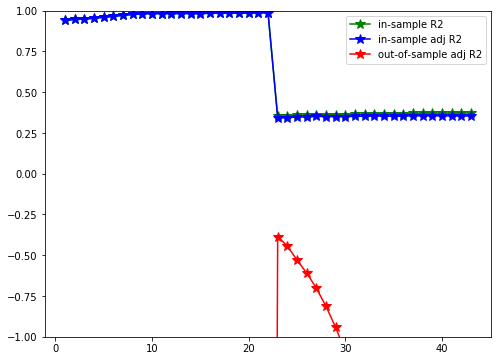

In [82]:
n = len(regressors)
plt.plot(range(1, n), regR2, 'g-*', markersize = 10)
plt.plot(range(1, n), adjR2, 'b-*', markersize = 10)
plt.plot(range(1, n), OSR2, 'r-*', markersize = 10)
plt.ylim((-1,1))
plt.legend(('in-sample R2','in-sample adj R2','out-of-sample adj R2'))

In [83]:
lm, r = AdjR2([1]*i + [0]*(len(regressors)-i))
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     36.75
Date:                Tue, 07 Jul 2020   Prob (F-statistic):          2.42e-123
Time:                        18:24:18   Log-Likelihood:                -3522.7
No. Observations:                1515   AIC:                             7091.
Df Residuals:                    1492   BIC:                             7214.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
num_providers      -0.8951      0.089    -10.105      0.000      -1.069      -0.721
k0_k10              0.0069      0.016      0.432      0.666      -0.025       0.038
k10_k15             0.0124      0.018      0.709      0.478      -0.022       0.047
k15_k25             0.0057      0.018      0.319      0.750      -0.030       0.041
k25_k35            -0.0096      0.020     -0.483      0.629      -0.049       0.029
k35_k50             0.0006      0.017      0.037      0.971      -0.033       0.034
k50_k75             0.0037      0.014      0.253      0.800      -0.025       0.032
k75_k100            0.0248      0.017      1.440      0.150      -0.009       0.059
k100_k150           0.0377      0.016      2.425      0.015       0.007       0.068
k150_k200           0.0537      0.020      2.648      0.008       0.014       0.094
k200_UP             0.0302      0.014      2.207      0.027       0.003       0.057
White              -0.0109      0.011     -0.954      0.340      -0.033       0.011
Black              -0.0034      0.011     -0.296      0.767      -0.026       0.019
Native              0.0083      0.062      0.133      0.894      -0.114       0.131
Asian              -0.0124      0.012     -1.040      0.299      -0.036       0.011
Other               0.0312      0.013      2.471      0.014       0.006       0.056
PacificIslander     0.0180      0.194      0.093      0.926      -0.363       0.399
TwoOrMore           0.0984      0.026      3.800      0.000       0.048       0.149
Bronx              70.2066      0.610    115.123      0.000      69.010      71.403
Brooklyn           72.9796      0.635    114.867      0.000      71.733      74.226
Queens             74.3417      0.602    123.589      0.000      73.162      75.522
Manhattan          73.2844      0.731    100.196      0.000      71.850      74.719
Staten_Island      76.7733      0.640    119.976      0.000      75.518      78.029
==============================================================================
Omnibus:                       64.581   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.965
Skew:                          -0.142   Prob(JB):                     8.34e-40
Kurtosis:                       4.665   Cond. No.                     1.37e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

According to the feature selecting, the number of providers, income, race and borough have relatively higher impact on the pricing of broadband.

In [151]:
# predict the pricing
selected_regressors = ['num_providers','k200_UP','White','Black','Native','Asian','Other','TwoOrMore','Bronx','Brooklyn','Queens','Manhattan','Staten_Island','No_Internet']
lm_D = sm.OLS(pqirbas['price'], pqirbas[selected_regressors]).fit()
lm_D.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     86.42
Date:                Tue, 07 Jul 2020   Prob (F-statistic):          2.43e-185
Time:                        18:52:00   Log-Likelihood:                -5048.2
No. Observations:                2165   AIC:                         1.012e+04
Df Residuals:                    2151   BIC:                         1.020e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
num_providers    -0.9306      0.075    -12.414      0.000      -1.078      -0.784
k200_UP           0.0423      0.009      4.939      0.000       0.026       0.059
White             0.0137      0.005      2.986      0.003       0.005       0.023
Black             0.0198      0.004      4.435      0.000       0.011       0.029
Native            0.0716      0.045      1.583      0.113      -0.017       0.160
Asian             0.0108      0.005      2.088      0.037       0.001       0.021
Other             0.0444      0.006      7.462      0.000       0.033       0.056
TwoOrMore         0.1208      0.019      6.478      0.000       0.084       0.157
Bronx            69.1955      0.505    137.039      0.000      68.205      70.186
Brooklyn         71.9922      0.524    137.465      0.000      70.965      73.019
Queens           73.7043      0.495    149.035      0.000      72.734      74.674
Manhattan        72.3542      0.604    119.808      0.000      71.170      73.539
Staten_Island    75.8177      0.522    145.188      0.000      74.794      76.842
No_Internet       0.0051      0.007      0.777      0.437      -0.008       0.018
==============================================================================
Omnibus:                      396.667   Durbin-Watson:                   1.520
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3215.110
Skew:                          -0.628   Prob(JB):                         0.00
Kurtosis:                       8.836   Cond. No.                     1.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [85]:
lm_S = sm.OLS(pqirbas['price'], pqirbas['num_providers']).fit()
lm_S.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                          3.452e+04
Date:                Tue, 07 Jul 2020   Prob (F-statistic):                        0.00
Time:                        18:24:18   Log-Likelihood:                         -9222.3
No. Observations:                2165   AIC:                                  1.845e+04
Df Residuals:                    2164   BIC:                                  1.845e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
num_providers    13.5453      0.073    185.785      0.000      13.402      13.688
==============================================================================
Omnibus:                      516.610   Durbin-Watson:                   0.585
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1078.530
Skew:                          -1.381   Prob(JB):                    6.31e-235
Kurtosis:                       5.081   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
pqirbas['Demand'] = lm_D.predict()
pqirbas['Supply'] = lm_S.predict()
pqirbas.head()

,num_providers,price,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,k100_k150,...,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP,Demand,Supply
0,3.0,53.326667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.629944,4.788136,1.384181,0.720339,0.000000,0.000000,0.000000,0.000000,68.628245,40.635943
1,4.0,68.747500,6.9,2.4,12.3,9.9,11.5,20.4,9.5,15.4,...,9.335095,3.478644,5.394100,7.243505,8.564509,2.091590,0.638485,2.377807,68.327710,54.181257
2,4.0,68.747500,7.2,1.9,7.6,3.5,8.5,18.0,17.2,17.3,...,7.241747,9.034434,5.378062,4.419595,3.727370,1.508697,1.384452,1.561945,68.236996,54.181257
3,4.0,68.747500,8.4,12.5,11.8,16.5,15.1,17.8,8.1,7.7,...,6.844685,6.540477,4.833531,3.735001,3.515295,4.613825,3.008281,1.842150,68.005255,54.181257
4,4.0,68.747500,13.7,10.3,6.7,7.2,18.2,19.3,12.4,10.7,...,5.858951,6.473779,2.820976,1.410488,0.289331,0.506329,0.542495,0.000000,68.820063,54.181257


In [87]:
Curve = pqirbas[['num_providers','Demand','Supply']]
Estimated_Demand = []
for i in range(len(Curve)):
    n_provider = Curve.loc[i,'num_providers']
    demand = Curve[Curve['num_providers']==n_provider]['Demand'].mean()
    Estimated_Demand.append(demand)
Curve['Estimated_Demand'] = np.array(Estimated_Demand)
# Curve = Curve.assign(Estimated_Demand = lambda x: np.exp(x['Estimated_Demand'])-1,
#                     Supply = lambda x: np.exp(x['Supply'])-1)
Curve = Curve.sort_values(by='num_providers')
Curve.head()

/Users/yanziyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,num_providers,Demand,Supply,Estimated_Demand
2164,1.0,74.887103,13.545314,74.887103
1953,2.0,71.843165,27.090629,70.987115
897,2.0,70.131066,27.090629,70.987115
2000,3.0,70.912596,40.635943,70.406479
1890,3.0,70.912596,40.635943,70.406479


<Figure size 576x432 with 0 Axes>

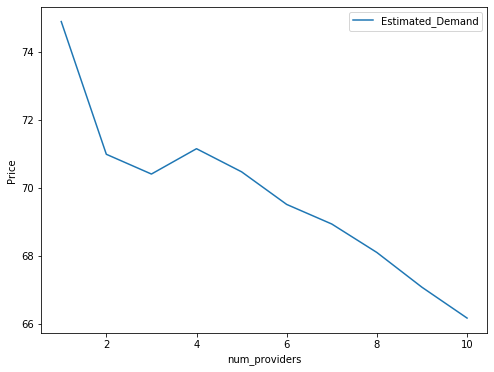

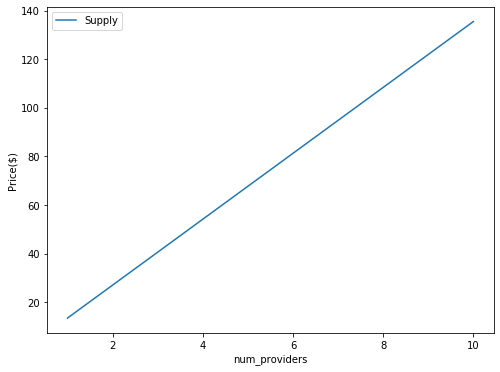

In [88]:
plt.figure()
Curve.plot(x='num_providers',y='Estimated_Demand')
plt.ylabel('Price')
Curve.plot(x='num_providers',y='Supply')
plt.ylabel('Price($)')
plt.legend(loc='best')

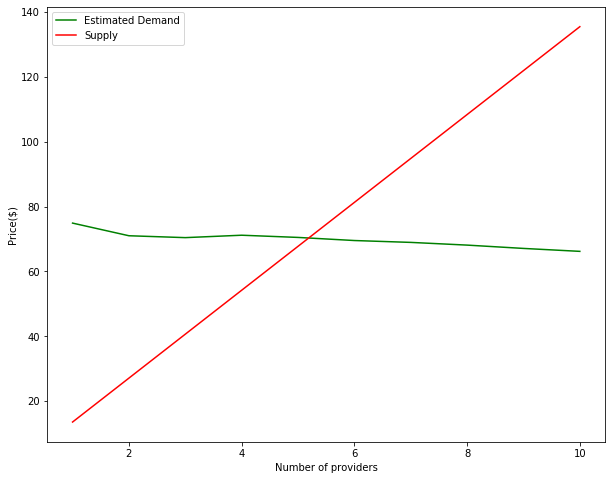

In [89]:
plt.figure(figsize=[10,8])
plt.plot(Curve['num_providers'],Curve['Estimated_Demand'],color='green', label='Estimated Demand')
plt.plot(Curve['num_providers'],Curve['Supply'],color='red', label='Supply')
# plt.ylim((0,150))
plt.ylabel('Price($)')
plt.xlabel('Number of providers')
plt.legend(loc='best')

The price of broadband has relatively less sensitivity to demand than supply. Given the current situation, the regression result indicates the optimal number of providers are near 5, which means it would be better for both customers to have choice and providers to gain more market share. the price ranges from [69.1, 89] per line per month approximately.

### For comparison, we redid the regression in 2017 datasets.

In [37]:
# merge data and get log value
pqi = broadband_ISP_merged_concise_2017.merge(income, on='BoroCTLbl')
pqir = pqi.merge(race, on='BoroCTLbl')
pqirb = pqir.merge(borough, on='BoroCTLbl')
pqirba = pqirb.merge(subscription_2017, on='BoroCTLbl')
pqirbas_2017 = pqirba.merge(age, on='BoroCTLbl')
pqirbas_2017 = pqirbas_2017.drop(columns=['BoroCTLbl','county','tract']).fillna(0)
# for i in pqirbas_2017.columns:
#     pqirbas_2017[i] = pqirbas_2017[i].apply(np.log1p)
pqirbas_2017.head()

,num_providers,price,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,k100_k150,...,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
0,3.0,53.326667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.957627,8.375706,8.629944,4.788136,1.384181,0.720339,0.000000,0.000000,0.000000,0.000000
1,4.0,68.747500,6.9,2.4,12.3,9.9,11.5,20.4,9.5,15.4,...,6.186702,8.080141,9.335095,3.478644,5.394100,7.243505,8.564509,2.091590,0.638485,2.377807
2,4.0,68.747500,7.2,1.9,7.6,3.5,8.5,18.0,17.2,17.3,...,6.886759,9.424920,7.241747,9.034434,5.378062,4.419595,3.727370,1.508697,1.384452,1.561945
3,4.0,68.747500,8.4,12.5,11.8,16.5,15.1,17.8,8.1,7.7,...,6.641879,6.084164,6.844685,6.540477,4.833531,3.735001,3.515295,4.613825,3.008281,1.842150
4,4.0,68.747500,13.7,10.3,6.7,7.2,18.2,19.3,12.4,10.7,...,6.907776,5.424955,5.858951,6.473779,2.820976,1.410488,0.289331,0.506329,0.542495,0.000000


In [38]:
# predict the pricing
selected_regressors = ['num_providers','k200_UP','White','Black','Native','Asian','Other','TwoOrMore','Bronx','Brooklyn','Queens','Manhattan','Staten_Island','No_Internet']
lm_D_2017 = sm.OLS(pqirbas_2017['price'], pqirbas_2017[selected_regressors]).fit()
lm_D_2017.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     85.15
Date:                Tue, 07 Jul 2020   Prob (F-statistic):          5.45e-183
Time:                        17:49:51   Log-Likelihood:                -5053.7
No. Observations:                2165   AIC:                         1.014e+04
Df Residuals:                    2151   BIC:                         1.021e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
num_providers    -0.9648      0.081    -11.922      0.000      -1.124      -0.806
k200_UP           0.0335      0.008      3.956      0.000       0.017       0.050
White             0.0147      0.005      3.196      0.001       0.006       0.024
Black             0.0209      0.004      4.662      0.000       0.012       0.030
Native            0.0775      0.045      1.708      0.088      -0.011       0.166
Asian             0.0114      0.005      2.196      0.028       0.001       0.022
Other             0.0454      0.006      7.556      0.000       0.034       0.057
TwoOrMore         0.1184      0.019      6.334      0.000       0.082       0.155
Bronx            69.3475      0.519    133.525      0.000      68.329      70.366
Brooklyn         72.0942      0.539    133.690      0.000      71.037      73.152
Queens           73.8836      0.512    144.203      0.000      72.879      74.888
Manhattan        71.4472      0.564    126.676      0.000      70.341      72.553
Staten_Island    76.0125      0.536    141.693      0.000      74.960      77.065
No_Internet       0.0012      0.006      0.185      0.853      -0.011       0.014
==============================================================================
Omnibus:                      416.107   Durbin-Watson:                   1.532
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3128.570
Skew:                          -0.696   Prob(JB):                         0.00
Kurtosis:                       8.722   Cond. No.                     1.25e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
lm_S_2017 = sm.OLS(pqirbas_2017['price'], pqirbas_2017['num_providers']).fit()
lm_S_2017.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          5.521e+04
Date:                Tue, 07 Jul 2020   Prob (F-statistic):                        0.00
Time:                        17:49:52   Log-Likelihood:                         -8737.9
No. Observations:                2165   AIC:                                  1.748e+04
Df Residuals:                    2164   BIC:                                  1.748e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
num_providers    14.5181      0.062    234.979      0.000      14.397      14.639
==============================================================================
Omnibus:                      182.970   Durbin-Watson:                   0.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.002
Skew:                          -0.798   Prob(JB):                     6.90e-51
Kurtosis:                       3.116   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
pqirbas_2017['Demand_2017'] = lm_D_2017.predict()
pqirbas_2017['Supply_2017'] = lm_S_2017.predict()
Curve_2017 = pqirbas_2017[['num_providers','Demand_2017','Supply_2017']]
Estimated_Demand = []
for i in range(len(Curve_2017)):
    n_provider = Curve_2017.loc[i,'num_providers']
    demand = Curve_2017[Curve_2017['num_providers']==n_provider]['Demand_2017'].mean()
    Estimated_Demand.append(demand)
Curve_2017['Estimated_Demand_2017'] = np.array(Estimated_Demand)
# Curve_2017 = Curve_2017.assign(Estimated_Demand_2017 = lambda x: np.exp(x['Estimated_Demand_2017'])-1,
#                     Supply_2017 = lambda x: np.exp(x['Supply_2017'])-1)
Curve_2017 = Curve_2017.sort_values(by='num_providers')
Curve_2017.head()

/Users/yanziyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,num_providers,Demand_2017,Supply_2017,Estimated_Demand_2017
2164,1.0,75.047696,14.518071,75.047696
1953,2.0,71.953972,29.036143,70.545368
1099,2.0,69.517554,29.036143,70.545368
897,2.0,70.164578,29.036143,70.545368
2000,3.0,70.989158,43.554214,70.300439


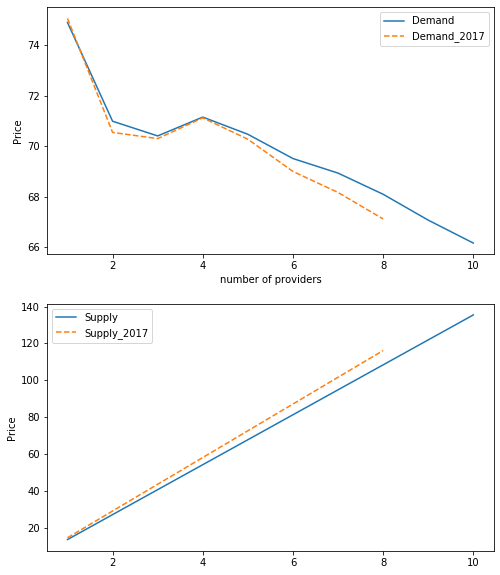

In [41]:
plt.figure(figsize=[8,10])
ax1 = plt.subplot(2, 1, 1)
plt.xlabel('number of providers')
plt.plot(Curve['num_providers'],Curve['Estimated_Demand'],'-',label='Demand')
plt.plot(Curve_2017['num_providers'],Curve_2017['Estimated_Demand_2017'],'--',label='Demand_2017')
plt.ylabel('Price')
plt.legend()
ax2 = plt.subplot(2, 1, 2)
plt.plot(Curve['num_providers'],Curve['Supply'],'-',label='Supply')
plt.plot(Curve_2017['num_providers'],Curve_2017['Supply_2017'],'--',label='Supply_2017')
plt.ylabel('Price')
plt.legend()

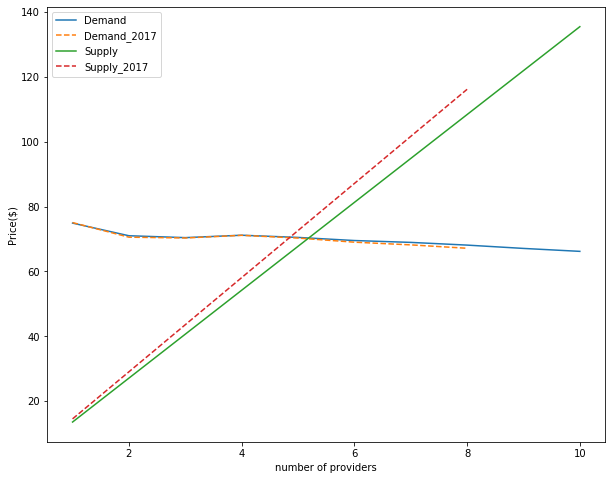

In [42]:
plt.figure(figsize=[10,8])
plt.xlabel('number of providers')
plt.plot(Curve['num_providers'],Curve['Estimated_Demand'],'-',label='Demand')
plt.plot(Curve_2017['num_providers'],Curve_2017['Estimated_Demand_2017'],'--',label='Demand_2017')
plt.ylabel('Price($)')
plt.plot(Curve['num_providers'],Curve['Supply'],'-',label='Supply')
plt.plot(Curve_2017['num_providers'],Curve_2017['Supply_2017'],'--',label='Supply_2017')
plt.legend()

Compared with the demand curve in 2017, the latest demand curve moves slightly upward, which may result from potential budget increase in the broadband service. People are willing to pay more for the internet access. Besides, the supply curve moves downward, which indicates new tech such as 5G may drag down the cost so the price and competition between companies increases.

### Draw the demand/supply plot for each borough

In [157]:
pqirbas = pqirbas.drop(columns=['Demand','Supply'])
pqirbas.head()

,num_providers,price,k0_k10,k10_k15,k15_k25,k25_k35,k35_k50,k50_k75,k75_k100,k100_k150,...,A40_A44,A45_A49,A50_A54,A55_A59,A60_A64,A65_A69,A70_A74,A75_A79,A80_A84,A85_UP
0,3.0,53.326667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.957627,8.375706,8.629944,4.788136,1.384181,0.720339,0.000000,0.000000,0.000000,0.000000
1,4.0,68.747500,6.9,2.4,12.3,9.9,11.5,20.4,9.5,15.4,...,6.186702,8.080141,9.335095,3.478644,5.394100,7.243505,8.564509,2.091590,0.638485,2.377807
2,4.0,68.747500,7.2,1.9,7.6,3.5,8.5,18.0,17.2,17.3,...,6.886759,9.424920,7.241747,9.034434,5.378062,4.419595,3.727370,1.508697,1.384452,1.561945
3,4.0,68.747500,8.4,12.5,11.8,16.5,15.1,17.8,8.1,7.7,...,6.641879,6.084164,6.844685,6.540477,4.833531,3.735001,3.515295,4.613825,3.008281,1.842150
4,4.0,68.747500,13.7,10.3,6.7,7.2,18.2,19.3,12.4,10.7,...,6.907776,5.424955,5.858951,6.473779,2.820976,1.410488,0.289331,0.506329,0.542495,0.000000


In [191]:
regressors = pqirbas.columns.tolist()
regressors.remove('price')
regressors.remove('Bronx')
regressors.remove('Brooklyn')
regressors.remove('Queens')
regressors.remove('Manhattan')
regressors.remove('Staten_Island')

In [129]:
def cal_mean(dataset):
    Estimated_Demand = []
    for i in range(len(dataset)):
        n_provider = dataset.loc[i,'num_providers']
        demand = dataset[dataset['num_providers']==n_provider]['Demand'].mean()
        Estimated_Demand.append(demand)
    dataset['Estimated_Demand'] = np.array(Estimated_Demand)
    new_dataset = dataset.sort_values(by='num_providers')
    return new_dataset

In [217]:
def plot(Curve, county):
    plt.figure(figsize=[5,4])
    plt.plot(Curve['num_providers'],Curve['Estimated_Demand'],color='green', label='Estimated Demand')
    plt.plot(Curve['num_providers'],Curve['Supply'],color='red', label='Supply')
    plt.title(county)
    if county=='Manhattan':
        plt.xlim([4,9])
    elif county=='Brooklyn':
        plt.xlim([4,7])
    elif county=='Queens':
        plt.xlim([4,5])
    elif county=='Bronx' or 'Staten_Island':
        plt.xlim([3,5])
    plt.ylabel('Price($)')
    plt.xlabel('Number of providers')
    plt.legend(loc='best')

In [218]:
def DS_for_borough(county):
    # county: 'Bronx','Brooklyn','Queens','Manhattan','Staten_Island'
    data = pqirbas[pqirbas[county]==1]
    data = data.reset_index().drop(columns=['index'])
    lm_D = sm.OLS(data['price'], data[regressors]).fit()
    lm_S = sm.OLS(data['price'], data['num_providers']).fit()
    data['Demand'] = lm_D.predict()
    data['Supply'] = lm_S.predict()
    Curve = data[['num_providers','Demand','Supply']]
    Curve = cal_mean(Curve)
    plot(Curve, county)

/Users/yanziyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/yanziyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/yanziyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

<Figure size 576x432 with 0 Axes>

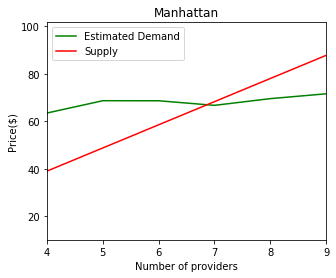

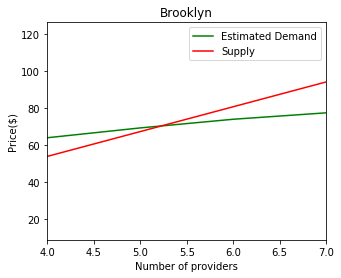

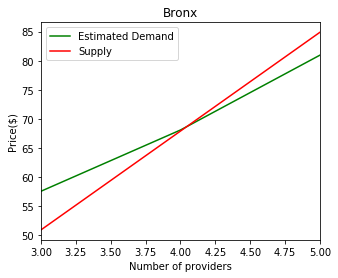

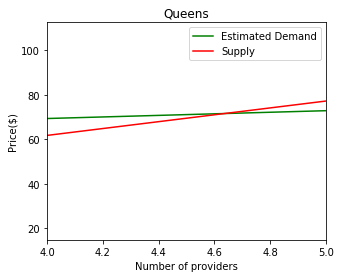

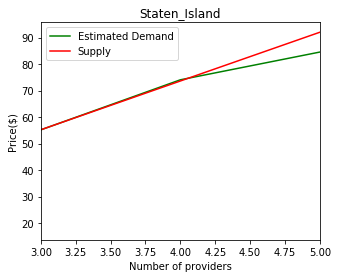

In [219]:
plt.figure(1)
DS_for_borough('Manhattan')
plt.figure(2)
DS_for_borough('Brooklyn')
plt.figure(3)
DS_for_borough('Bronx')
plt.figure(4)
DS_for_borough('Queens')
plt.figure(5)
DS_for_borough('Staten_Island')

For this part, we mainly focus on the difference of the optimal number of providers, which is the cross point in each figure. We can see that, in Manhattan, the optimal number is near 7, 5 in Brooklyn, 4 in Bronx and Staten Island and 4.6 (near 5) in Queens.